In [13]:
# Standard library
import os
import time

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import uniform, randint

# Machine Learning
import lightgbm as lgb
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge,RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import mean_squared_error


# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.shadow'] = False
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['lines.linewidth'] = 2

# Set seaborn style for even nicer plots

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# ID_COLS = ['id', 'student_id']
# TARGET = 'exam_score'

# SLEEP_MAP = {'poor': 0, 'average': 1, 'good': 2}
# FACILITY_MAP = {'low': 0, 'medium': 1, 'high': 2}
# DIFFICULTY_MAP = {'easy': 0, 'moderate': 1, 'hard': 2}

# #CATEGORICAL_COLS = ['sleep_quality', 'facility_rating', 'study_method',
# #                    'course', 'exam_difficulty', 'gender', 'internet_access']


# CAT_COLS = ['sleep_quality', 'facility_rating', 'study_method',
#             'course', 'exam_difficulty', 'gender', 'internet_access']


ID_COLS = ['id', 'student_id']
TARGET = 'exam_score'

# drop these completely (raw features)
DROP_COLS = ['age', 'gender', 'internet_access']

SLEEP_MAP = {'poor': 0, 'average': 1, 'good': 2}
FACILITY_MAP = {'low': 0, 'medium': 1, 'high': 2}
DIFFICULTY_MAP = {'easy': 0, 'moderate': 1, 'hard': 2}

# removed gender + internet_access here
CATEGORICAL_COLS = [
    'sleep_quality', 'facility_rating', 'study_method',
    'course', 'exam_difficulty'
]

In [2]:
def load_data(data_dir='data'):
    """
    Load train, train_original, and test datasets.
    Combines train.csv and train_original.csv into a single training dataframe.
    """
    # Load individual files
    train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    train_original = pd.read_csv(os.path.join(data_dir, 'train_original.csv'))
    test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

    # Combine training datasets
    train_combined = pd.concat([train, train_original], axis=0,
                               ignore_index=True)

    return train_combined, test, train, train_original


def prepare_features(df, is_test=False):
    """
    Separate features and target variable.
    Handles cases where 'id' column may not exist.
    """
    df = df.copy()

    # Drop id if it exists
    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    if is_test:
        return df, None
    else:
        X = df.drop(columns=['exam_score'])
        y = df['exam_score']
        return X, y



In [4]:
# Load the data
train_data, test_data, train_only, train_original = load_data(data_dir="./")

# Prep data
X_train, y_train = prepare_features(train_data)
X_test, _ = prepare_features(test_data, is_test=True)
print(len(y_train),len(X_train))

650000 650000


Numerical features: ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'student_id']
Categorical features: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


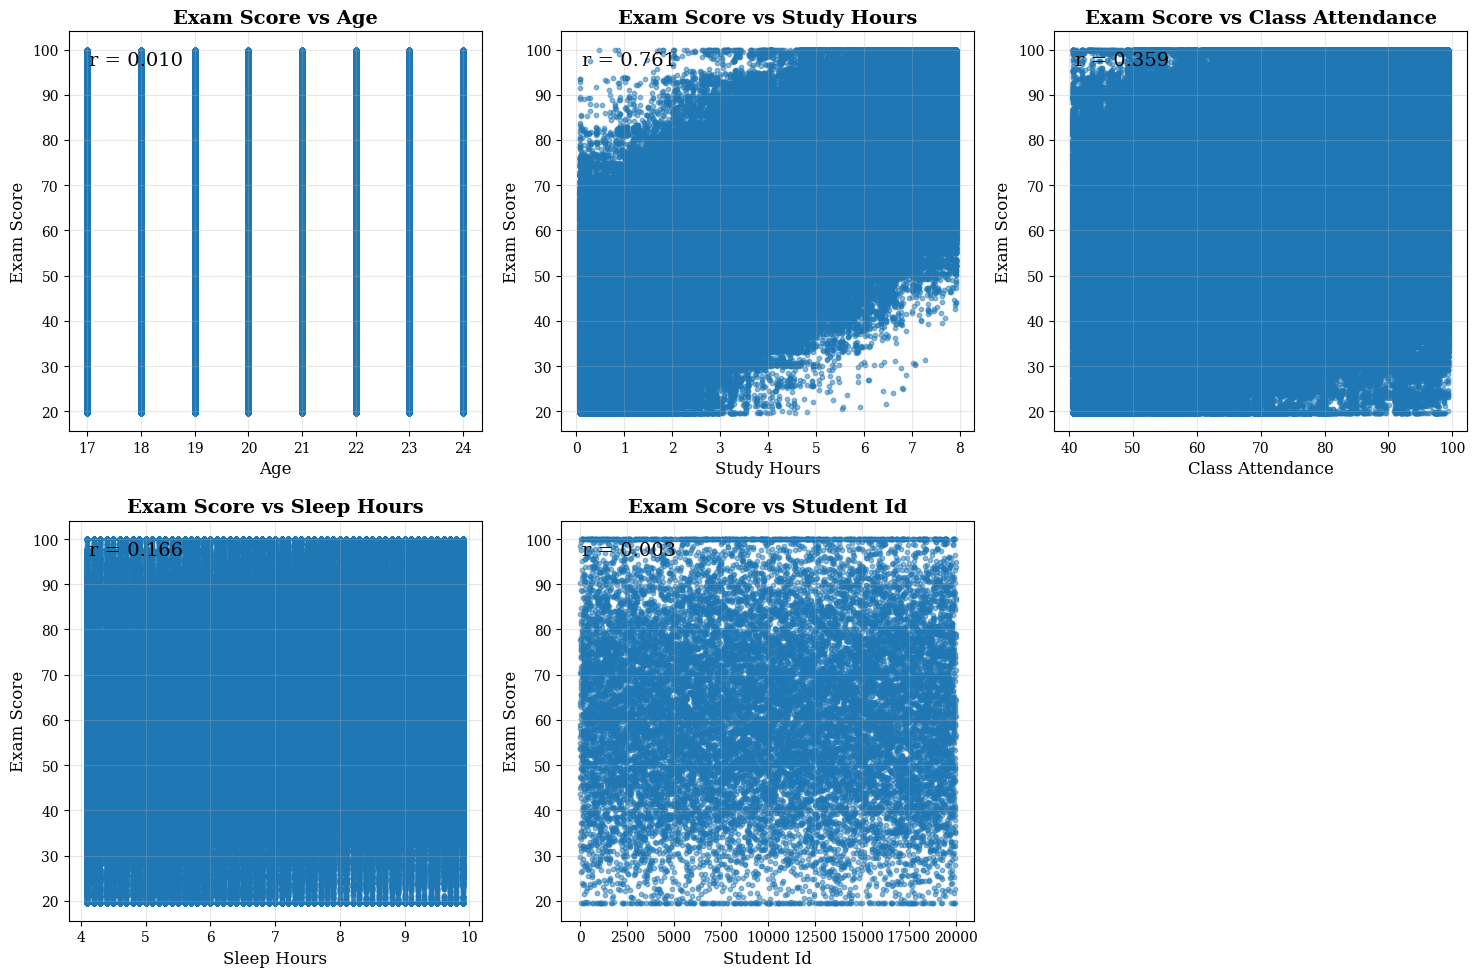

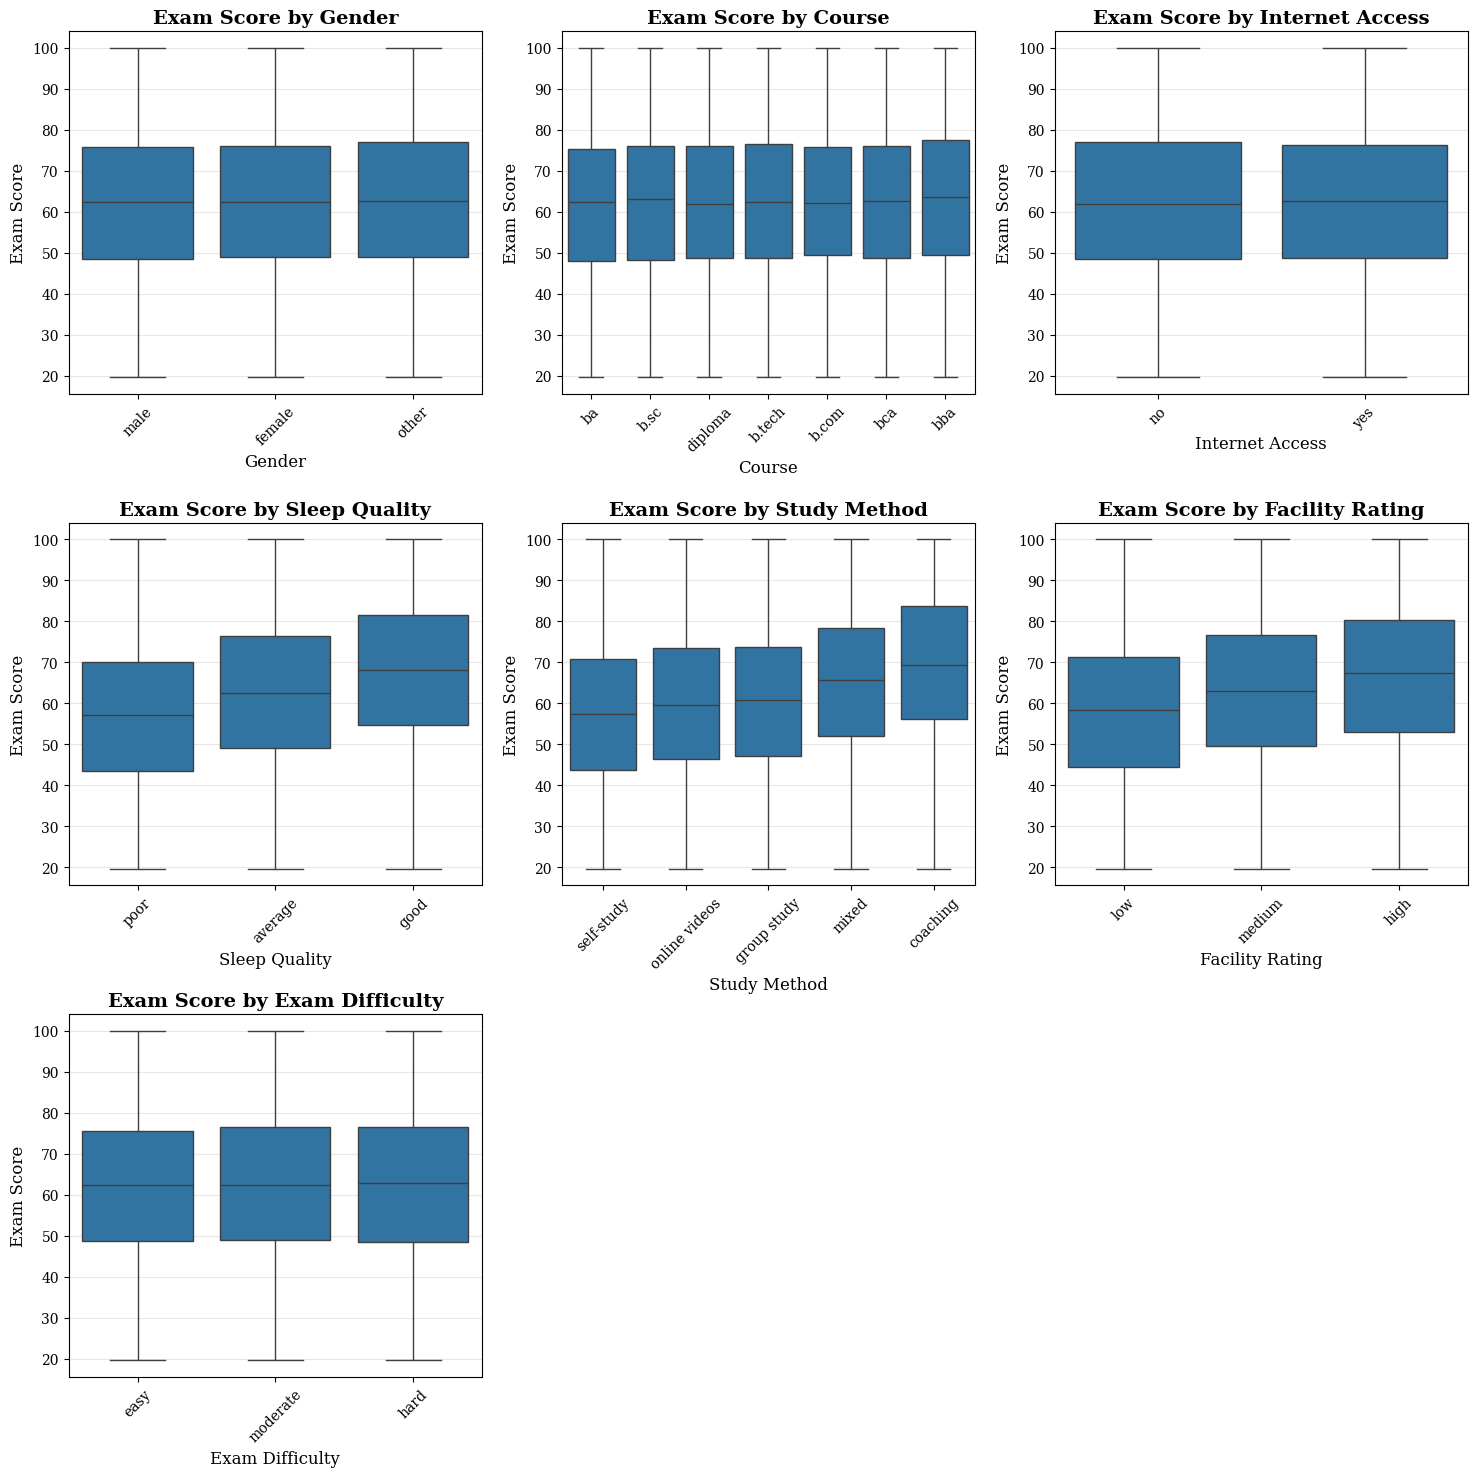

Statistical Summary - Categorical Features

GENDER:
         count       mean        std
gender                              
other   217823  62.774393  19.083944
female  214889  62.563799  18.896342
male    217288  62.182399  18.762858

COURSE:
          count       mean        std
course                               
bba       78480  63.221056  19.157103
bca       91623  62.584259  18.919004
b.com    113796  62.532579  18.410132
b.tech   134034  62.522501  18.865253
diploma   52750  62.400404  19.085984
b.sc     114432  62.306142  19.289985
ba        64885  61.896986  18.771322

INTERNET_ACCESS:
                  count       mean        std
internet_access                              
yes              596411  62.507512  18.884247
no                53589  62.499768  19.273317

SLEEP_QUALITY:
                count       mean        std
sleep_quality                              
good           219708  67.862402  18.124274
average        209930  62.657807  18.601161
poor           220

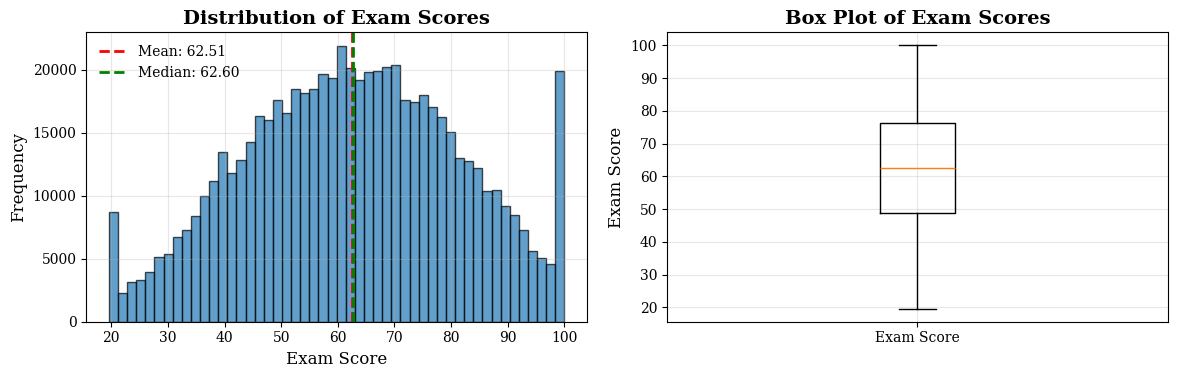

exam_score statistics:
  Mean: 62.51
  Median: 62.60
  Std: 18.92
  Min: 19.60
  Max: 100.00


In [5]:
#Start by looking at the data, this is standard pandas and matplotlib
#identify numerical vs categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# 1. Numerical Features - Scatter Plots
n_numerical = len(numerical_features)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    if idx < len(axes):
        axes[idx].scatter(X_train[feature], y_train, alpha=0.5, s=10)
        axes[idx].set_xlabel(feature.replace('_', ' ').title())
        axes[idx].set_ylabel('Exam Score')
        axes[idx].set_title(f'Exam Score vs {feature.replace("_", " ").title()}')

        # Add correlation coefficient
        corr = X_train[feature].corr(y_train)
        axes[idx].text(0.05, 0.95, f'r = {corr:.3f}',
                      transform=axes[idx].transAxes,
                      verticalalignment='top')

# Remove empty subplots
for idx in range(n_numerical, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('numerical_features_vs_score.png', bbox_inches='tight')
plt.show()

# 2. Categorical Features - Box Plots
n_categorical = len(categorical_features)
n_cols = 3
n_rows = (n_categorical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feature in enumerate(categorical_features):
    if idx < len(axes):
        # Create dataframe for easier plotting
        plot_data = pd.DataFrame({
            'category': X_train[feature],
            'score': y_train
        })

        # Calculate mean scores for sorting
        mean_scores = plot_data.groupby('category')['score'].mean().sort_values()

        # Box plot
        sns.boxplot(data=plot_data, x='category', y='score',
                   order=mean_scores.index, ax=axes[idx])
        axes[idx].set_xlabel(feature.replace('_', ' ').title())
        axes[idx].set_ylabel('Exam Score')
        axes[idx].set_title(f'Exam Score by {feature.replace("_", " ").title()}')
        axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplots
for idx in range(n_categorical, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('categorical_features_vs_score.png', bbox_inches='tight')
plt.show()


# 3. Statistical Summary
print("Statistical Summary - Categorical Features")
for feature in categorical_features:
    print(f"\n{feature.upper()}:")
    summary = train_data.groupby(feature)['exam_score'].agg(['count', 'mean', 'std'])
    summary = summary.sort_values('mean', ascending=False)
    print(summary.to_string())

print("Correlation - Numerical Features")
# Correlation with target
corr_with_target = X_train[numerical_features].corrwith(y_train).sort_values(ascending=False)
print("Correlation with Exam Score:")
print(corr_with_target.to_string())


# 4. Distribution of Target Variable
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Scores')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {y_train.mean():.2f}')
axes[0].axvline(y_train.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {y_train.median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(y_train, vert=True)
axes[1].set_ylabel('Exam Score')
axes[1].set_title('Box Plot of Exam Scores')
axes[1].set_xticklabels(['Exam Score'])

plt.tight_layout()
plt.savefig('target_distribution.png', bbox_inches='tight')
plt.show()

print(f"exam_score statistics:")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Median: {y_train.median():.2f}")
print(f"  Std: {y_train.std():.2f}")
print(f"  Min: {y_train.min():.2f}")
print(f"  Max: {y_train.max():.2f}")

Strongest Predictors
*    Study Hours - The single strongest predictor.
*    Class Attendance - Good indicator
*    Sleep Quality & Exam Difficulty - Large score differences between categories

Bad Predictors, consider dropping.   
*   Gender: Nearly identical scores, might not add predictive value.
*   Age: Weak correlation.


    

In [6]:
# Outlier Detection
# A fast check for outliers

# Get numerical features
numerical_features = ['age', 'study_hours', 'class_attendance', 'sleep_hours']

z_scores = np.abs(stats.zscore(train_data[numerical_features]))
outliers_zscore = (z_scores > 3).any(axis=1) #3 SD way
print(f"  Outliers: {outliers_zscore.sum()} ({outliers_zscore.sum()/len(train_data)*100:.2f}%)\n")



  Outliers: 0 (0.00%)



/tmp/ipython-input-2637329526.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = train_data.groupby(bins)['exam_score'].agg(['mean', 'std', 'count'])
/tmp/ipython-input-2637329526.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = train_data.groupby(bins)['exam_score'].agg(['mean', 'std', 'count'])
/tmp/ipython-input-2637329526.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = train_data.group


STUDY_HOURS:
                    mean        std   count
study_hours                                
(0.079, 1.56]  42.652823  12.655360  130372
(1.56, 3.17]   52.030818  12.925783  130477
(3.17, 4.78]   63.091123  12.676707  130155
(4.78, 6.44]   72.641735  12.624325  129060
(6.44, 7.91]   82.295451  11.944718  129936
  Bin 0→1: +9.38
  Bin 1→2: +11.06
  Bin 2→3: +9.55
  Bin 3→4: +9.65

CLASS_ATTENDANCE:
                                 mean        std   count
class_attendance                                        
(40.599000000000004, 53.4]  52.611506  17.644170  130391
(53.4, 66.8]                58.076303  18.096619  130118
(66.8, 78.4]                63.300422  17.908643  130581
(78.4, 89.9]                66.910971  17.564041  129088
(89.9, 99.4]                71.708901  17.285043  129822
  Bin 0→1: +5.46
  Bin 1→2: +5.22
  Bin 2→3: +3.61
  Bin 3→4: +4.80

SLEEP_HOURS:
                               mean        std   count
sleep_hours                                           

/tmp/ipython-input-2637329526.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = train_data.groupby(bins)['exam_score'].mean()
/tmp/ipython-input-2637329526.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = train_data.groupby(bins)[feature].mean()
/tmp/ipython-input-2637329526.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = train_data.groupby(bins)['exam_score'].mean()
/tmp

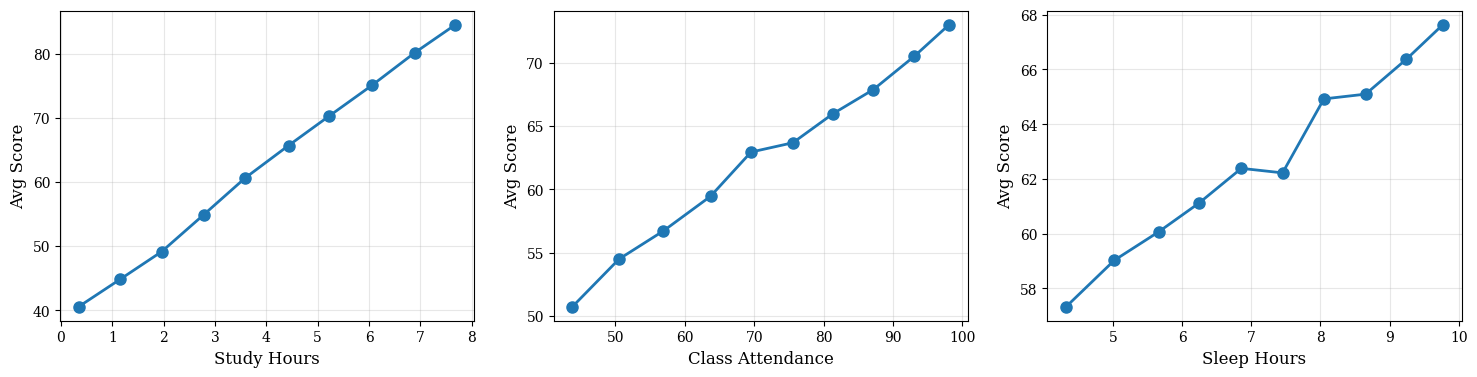

Threshold analysis

STUDY_HOURS:
  25th pct (≤2.0 vs >2.0): Δ = 25.24
  50th pct (≤4.0 vs >4.0): Δ = 25.12
  75th pct (≤6.0 vs >6.0): Δ = 24.81
  90th pct (≤7.3 vs >7.3): Δ = 24.39

CLASS_ATTENDANCE:
  25th pct (≤57.0 vs >57.0): Δ = 12.37
  50th pct (≤72.5 vs >72.5): Δ = 11.32
  75th pct (≤87.1 vs >87.1): Δ = 11.41
  90th pct (≤95.8 vs >95.8): Δ = 11.61

SLEEP_HOURS:
  25th pct (≤5.6 vs >5.6): Δ = 5.67
  50th pct (≤7.1 vs >7.1): Δ = 5.27
  75th pct (≤8.6 vs >8.6): Δ = 5.34
  90th pct (≤9.5 vs >9.5): Δ = 5.59
Transformation comparison

study_hours:
  original: 0.7609
  log     : 0.7340
  sqrt    : 0.7448
  square  : 0.7346
  cube    : 0.6934

class_attendance:
  original: 0.3593
  log     : 0.3588
  sqrt    : 0.3596
  square  : 0.3557
  cube    : 0.3490

sleep_hours:
  original: 0.1664
  log     : 0.1657
  sqrt    : 0.1662
  square  : 0.1653
  cube    : 0.1628


In [7]:
# Feature Analysis - Binned relationships and transformations
# Try to see what matters and if we can drop something, might be usefull later.

# Binned analysis
def analyze_bins(feature, n_bins=5):
    bins = pd.qcut(train_data[feature], q=n_bins, duplicates='drop')
    stats = train_data.groupby(bins)['exam_score'].agg(['mean', 'std', 'count'])
    print(f"\n{feature.upper()}:")
    print(stats)

    # Marginal improvements
    means = stats['mean'].values
    for i, imp in enumerate(np.diff(means)):
        print(f"  Bin {i}→{i+1}: {imp:+.2f}")

for f in ['study_hours', 'class_attendance', 'sleep_hours']:
    analyze_bins(f)

# Visual analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, feature in enumerate(['study_hours', 'class_attendance', 'sleep_hours']):
    bins = pd.qcut(train_data[feature], q=10, duplicates='drop')
    bin_means = train_data.groupby(bins)['exam_score'].mean()
    bin_centers = train_data.groupby(bins)[feature].mean()

    axes[idx].plot(bin_centers, bin_means, 'o-', linewidth=2, markersize=8)
    axes[idx].set_xlabel(feature.replace('_', ' ').title())
    axes[idx].set_ylabel('Avg Score')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_analysis.png', bbox_inches='tight')
plt.show()

# Threshold analysis

print("Threshold analysis")
for feature in ['study_hours', 'class_attendance', 'sleep_hours']:
    print(f"\n{feature.upper()}:")
    for pct in [25, 50, 75, 90]:
        thresh = train_data[feature].quantile(pct/100)
        below = train_data[train_data[feature] <= thresh]['exam_score'].mean()
        above = train_data[train_data[feature] > thresh]['exam_score'].mean()
        print(f"  {pct}th pct (≤{thresh:.1f} vs >{thresh:.1f}): Δ = {above-below:.2f}")

# Transformation comparison

print("Transformation comparison")

transforms = {
    'log': lambda x: np.log1p(x),
    'sqrt': lambda x: np.sqrt(x),
    'square': lambda x: x ** 2,
    'cube': lambda x: x ** 3
}

for feature in ['study_hours', 'class_attendance', 'sleep_hours']:
    print(f"\n{feature}:")
    orig = train_data[feature].corr(train_data['exam_score'])
    print(f"  original: {orig:.4f}")
    for name, func in transforms.items():
        corr = func(train_data[feature]).corr(train_data['exam_score'])
        print(f"  {name:8s}: {corr:.4f}")

Data: (20000, 11)

Ridge           RMSE: 10.8854 (±0.0731) [1.1s]
Lasso           RMSE: 10.8832 (±0.0714) [0.9s]
ElasticNet      RMSE: 10.9135 (±0.0570) [0.9s]
MLP             RMSE: 10.1280 (±0.0419) [5.7s]
ExtraTrees      RMSE: 10.2808 (±0.0279) [0.9s]
XGBoost         RMSE: 9.9756 (±0.0937) [0.2s]
LightGBM        RMSE: 9.9758 (±0.0767) [1.3s]

     Model      RMSE      Std     Time
   XGBoost  9.975633 0.093654 0.216319
  LightGBM  9.975796 0.076664 1.296627
       MLP 10.127982 0.041935 5.740493
ExtraTrees 10.280816 0.027878 0.855292
     Lasso 10.883173 0.071434 0.886595
     Ridge 10.885391 0.073065 1.108373
ElasticNet 10.913511 0.057023 0.866853


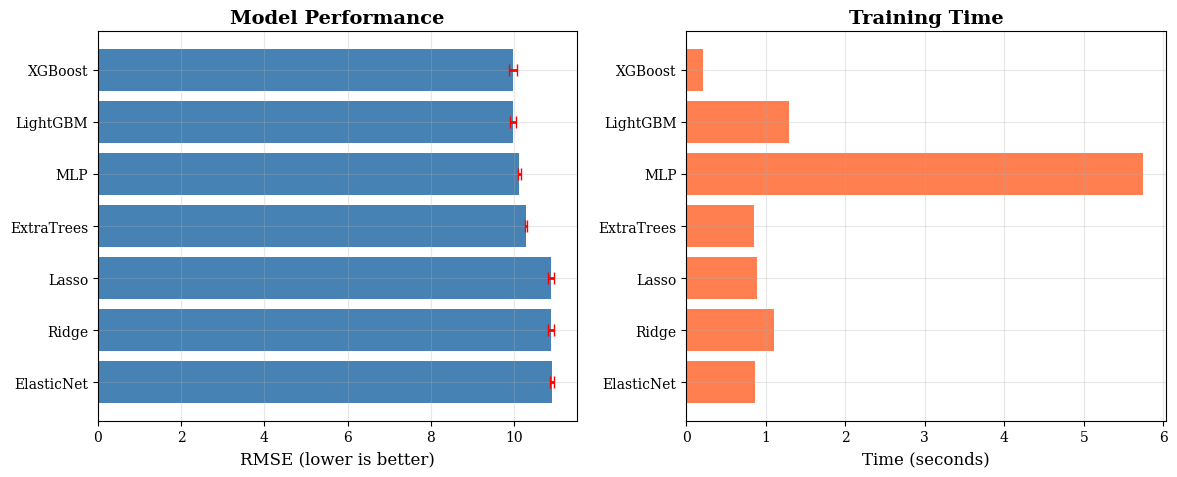

In [8]:
# Quick Model Test
# Load raw data
df = pd.read_csv("train_original.csv")
y = df['exam_score']
X = df.drop(columns=['exam_score', 'student_id'])

# Simple encoding: convert categoricals to numbers
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category').cat.codes

print(f"Data: {X.shape}\n")

# Models
def scaled(model):
    return Pipeline([('scaler', StandardScaler()), ('model', model)])

models = {
    'Ridge': scaled(Ridge(alpha=10)),
    'Lasso': scaled(Lasso(alpha=0.1)),
    'ElasticNet': scaled(ElasticNet(alpha=0.1, l1_ratio=0.5)),
    'MLP': scaled(MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=300,
                                early_stopping=True, random_state=RANDOM_STATE)),
    #'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10,
    #                                      n_jobs=-1, random_state=RANDOM_STATE),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=100, max_depth=10,
                                      n_jobs=-1, random_state=RANDOM_STATE),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                                random_state=RANDOM_STATE),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                                  random_state=RANDOM_STATE, verbose=-1),
}


# Run
results = []
for name, model in models.items():
    start = time.time()
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse = np.sqrt(-scores)
    elapsed = time.time() - start

    results.append({'Model': name, 'RMSE': rmse.mean(), 'Std': rmse.std(), 'Time': elapsed})
    print(f"{name:15} RMSE: {rmse.mean():.4f} (±{rmse.std():.4f}) [{elapsed:.1f}s]")

# Summary
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\n" + "="*50)
print(results_df.to_string(index=False))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE comparison
axes[0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0].errorbar(results_df['RMSE'], results_df['Model'],
                 xerr=results_df['Std'], fmt='none', color='red', capsize=4)
axes[0].set_xlabel('RMSE (lower is better)')
axes[0].set_title('Model Performance')
axes[0].invert_yaxis()

# Time comparison
axes[1].barh(results_df['Model'], results_df['Time'], color='coral')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title('Training Time')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('quick_model_comparison.png', bbox_inches='tight')
plt.show()

# Train
Now we can get to traning, but we need to transform the data into a
format that fits ML models better, in other words: numbers.
This will be done using standard sklearn tools, simple and easy to use.
The problem is not so complex that we need custom classes for any of this.


In [9]:
def add_features(X):
    X = X.copy()
    eps = 1e-5

    # Coerce numerics (age removed)
    for c in ['study_hours', 'class_attendance', 'sleep_hours']:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce")

    # Squared
    X['study_hours_squared'] = X['study_hours'] ** 2
    X['class_attendance_squared'] = X['class_attendance'] ** 2
    X['sleep_hours_squared'] = X['sleep_hours'] ** 2

    # Log
    X['log_study_hours'] = np.log1p(X['study_hours'])
    X['log_class_attendance'] = np.log1p(X['class_attendance'])
    X['log_sleep_hours'] = np.log1p(X['sleep_hours'])

    # Ordinal encodings
    X['sleep_quality_num'] = X['sleep_quality'].map(SLEEP_MAP).fillna(1)
    X['facility_rating_num'] = X['facility_rating'].map(FACILITY_MAP).fillna(1)
    X['exam_difficulty_num'] = X['exam_difficulty'].map(DIFFICULTY_MAP).fillna(1)

    # Interactions (numeric * numeric)
    X['study_x_attendance'] = X['study_hours'] * X['class_attendance']
    X['study_x_sleep'] = X['study_hours'] * X['sleep_hours']
    X['attendance_x_sleep'] = X['class_attendance'] * X['sleep_hours']

    # Ratios
    X['study_over_sleep'] = X['study_hours'] / (X['sleep_hours'] + eps)
    X['attendance_over_sleep'] = X['class_attendance'] / (X['sleep_hours'] + eps)

    # Interactions (numeric * ordinal)
    X['study_x_sleep_quality'] = X['study_hours'] * X['sleep_quality_num']
    X['attendance_x_facility'] = X['class_attendance'] * X['facility_rating_num']
    X['sleep_x_difficulty'] = X['sleep_hours'] * X['exam_difficulty_num']

    # Efficiency
    X['efficiency'] = (X['study_hours'] * X['class_attendance']) / (X['sleep_hours'] + 1)

    # Edge-case helpers (optional; keep if you want)
    X['low_hours_gate']  = 1.0 / (1.0 + X['study_hours'])
    X['high_hours_gate'] = X['study_hours'] / (1.0 + X['study_hours'])

    context = (
        0.6 * (X['sleep_quality_num'] / 2.0) +
        0.6 * (X['facility_rating_num'] / 2.0) +
        0.3 * (1.0 - X['exam_difficulty_num'] / 2.0)
    )
    X['context_score'] = context
    X['risk_score'] = (1.5 - context)

    X['efficient_potential'] = (
        X['low_hours_gate'] *
        (X['class_attendance'] / 100.0) *
        (1.0 + X['context_score'])
    )
    X['struggle_risk'] = (
        X['high_hours_gate'] *
        (1.0 - (X['class_attendance'] / 100.0)) *
        (1.0 + X['risk_score'])
    )

    return X.fillna(0)

def preprocess(X_train, X_test, X_orig=None):
    """
    Drop unused cols, add features, align categoricals, align columns.
    """

    # Drop IDs + unused cols (consistently)
    drop = [c for c in (ID_COLS + DROP_COLS) if c in X_train.columns]
    X_train = X_train.drop(columns=drop, errors='ignore')
    X_test  = X_test.drop(columns=drop,  errors='ignore')
    if X_orig is not None:
        X_orig = X_orig.drop(columns=drop, errors='ignore')

    # Feature engineering
    X_train = add_features(X_train)
    X_test  = add_features(X_test)
    if X_orig is not None:
        X_orig = add_features(X_orig)

    # Categorical handling
    cat_cols = [c for c in CATEGORICAL_COLS if c in X_train.columns]
    for c in cat_cols:
        X_train[c] = X_train[c].astype('category')
        X_test[c]  = X_test[c].astype('category')
        if X_orig is not None:
            X_orig[c] = X_orig[c].astype('category')

        all_cats = pd.Index(X_train[c].cat.categories).union(X_test[c].cat.categories)
        if X_orig is not None:
            all_cats = all_cats.union(X_orig[c].cat.categories)

        X_train[c] = X_train[c].cat.set_categories(all_cats)
        X_test[c]  = X_test[c].cat.set_categories(all_cats)
        if X_orig is not None:
            X_orig[c] = X_orig[c].cat.set_categories(all_cats)

    # Align columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    if X_orig is not None:
        X_orig = X_orig.reindex(columns=X_train.columns, fill_value=0)

    return X_train, X_test, X_orig


In [10]:
X_train_main, y_train_main = prepare_features(train_only)
X_orig, y_orig = prepare_features(train_original)
X_test, _ = prepare_features(test_data, is_test=True)

# Preprocess all at once
X_train_main, X_test, X_orig = preprocess(X_train_main, X_test, X_orig)
feature_names = list(X_train_main.columns)

print(f"Features: {len(feature_names)}")
print(f"Train: {X_train_main.shape}, Orig: {X_orig.shape}, Test: {X_test.shape}")

Features: 32
Train: (630000, 32), Orig: (20000, 32), Test: (270000, 32)


In [ ]:
# -----------------------------------------------------------------------------
# Final training attempt
#
# This solution combines:
#   1) My own feature engineering and cross-validation workflow.
#   2) A Ridge-based approach inspired by the Kaggle notebook:
#      "s6e1-learned-lr-formula-xgb" by haha750
#      (reference: https://www.kaggle.com/code/haha750/s6e1-learned-lr-formula-xgb/notebook)

# Key ideas adopted/extended:
#   - Use a strong linear baseline (Ridge) with target-encoded categorical features
#     to capture stable, global structure.
#   - Add gradient-boosted trees (LightGBM/XGBoost) to model non-linear effects and
#     interactions that a linear model cannot.
#   - Ensemble the models to reduce variance and improve robustness.
#   - Evaluate simple post-processing calibration (isotonic regression) on out-of-fold
#     predictions to mitigate regression-to-the-mean effects.
#
# Notes:
#   - Feature engineering is a mix of notebook-inspired transformations and my own
#     additions, iterated based on cross-validation results.
#   - Final settings reflect insights from hyperparameter tuning, calibration
#     experiments, and residual/error analysis.
#   - The main remaining failure mode is regression-to-the-mean: the model tends to
#     underpredict high-performing students with low study hours and overpredict
#     low-performing students with high study hours. I tested additional features
#     aimed at separating these edge cases, but they did not improve CV performance,
#     so the final version keeps a simpler feature set consistent with other strong
#     leaderboard solutions.
#   - I tried a combination of LightGBM and XGBoost, it did worse. XGBoost alone
#     does better with the setup I landed on. Results from test:
#     Best blend: LGB=0.00, XGB=1.00, RMSE=8.7304

# -----------------------------------------------------------------------------

In [14]:
RANDOM_STATE = 6361274
FOLDS = 3
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

cat_cols = X_train_main.select_dtypes(include=['category']).columns.tolist()
print(f"Features: {X_train_main.shape[1]}, Categoricals: {len(cat_cols)}")

# =============================================================================
# STAGE 1: Ridge
# =============================================================================

print("\n" + "="*60)
print("STAGE 1: Ridge")
print("="*60)

oof_ridge = np.zeros(len(X_train_main))
test_ridge = np.zeros((len(X_test), FOLDS))
orig_ridge = np.zeros(len(X_orig))

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train_main), 1):
    X_tr = pd.concat([X_train_main.iloc[tr_idx], X_orig], ignore_index=True)
    y_tr = pd.concat([y_train_main.iloc[tr_idx], y_orig], ignore_index=True)
    X_va = X_train_main.iloc[va_idx].copy()
    X_te = X_test.copy()
    X_or = X_orig.copy()
    y_va = y_train_main.iloc[va_idx]

    if cat_cols:
        te = TargetEncoder(smooth='auto', target_type='continuous')
        X_tr[cat_cols] = te.fit_transform(X_tr[cat_cols].astype(str), y_tr)
        X_va[cat_cols] = te.transform(X_va[cat_cols].astype(str))
        X_te[cat_cols] = te.transform(X_te[cat_cols].astype(str))
        X_or[cat_cols] = te.transform(X_or[cat_cols].astype(str))

    X_tr = X_tr.astype(float).fillna(0)
    X_va = X_va.astype(float).fillna(0)
    X_te = X_te.astype(float).fillna(0)
    X_or = X_or.astype(float).fillna(0)

    ridge = RidgeCV(alphas=np.logspace(-3, 1, 25), cv=5,
                    scoring='neg_root_mean_squared_error')
    ridge.fit(X_tr, y_tr)

    oof_ridge[va_idx] = np.clip(ridge.predict(X_va), 0, 100)
    test_ridge[:, fold-1] = np.clip(ridge.predict(X_te), 0, 100)
    orig_ridge += np.clip(ridge.predict(X_or), 0, 100) / FOLDS

    rmse = np.sqrt(mean_squared_error(y_va, oof_ridge[va_idx]))
    print(f"Fold {fold}: RMSE={rmse:.4f}, alpha={ridge.alpha_:.4f}")

print(f"Ridge OOF: {np.sqrt(mean_squared_error(y_train_main, oof_ridge)):.4f}")

# Add ridge predictions as feature
X_train_stack = X_train_main.copy()
X_test_stack = X_test.copy()
X_orig_stack = X_orig.copy()

X_train_stack['ridge_pred'] = oof_ridge
X_test_stack['ridge_pred'] = test_ridge.mean(axis=1)
X_orig_stack['ridge_pred'] = orig_ridge

# =============================================================================
# STAGE 2: XGBoost
# =============================================================================

print("\n" + "="*60)
print("STAGE 2: XGBoost")
print("="*60)

for col in cat_cols:
    X_train_stack[col] = X_train_stack[col].astype(str).astype('category')
    X_test_stack[col] = X_test_stack[col].astype(str).astype('category')
    X_orig_stack[col] = X_orig_stack[col].astype(str).astype('category')

XGB_PARAMS = {
    # Core
    'n_estimators': 15000,
    'learning_rate': 0.01,
    'max_depth': 7,

    # Regularization
    'reg_lambda': 10,
    'reg_alpha': 0.5,
    'min_child_weight': 10,  #

    # Sampling
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.6,
    'colsample_bynode': 0.6,

    # Technical
    'tree_method': 'hist',
    'enable_categorical': True,
    'early_stopping_rounds': 100,
    'eval_metric': 'rmse',
    'random_state': 42,
    'device': 'cuda',
}

oof_xgb = np.zeros(len(X_train_main))
test_xgb = np.zeros(len(X_test))

X_full = pd.concat([X_train_stack, X_orig_stack], ignore_index=True)
y_full = pd.concat([y_train_main, y_orig], ignore_index=True)
n_train = len(X_train_stack)
orig_idx = np.arange(n_train, len(X_full))

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train_stack), 1):
    t0 = time.time()

    tr_idx_full = np.concatenate([tr_idx, orig_idx])
    X_tr = X_full.iloc[tr_idx_full]
    y_tr = y_full.iloc[tr_idx_full]
    X_va = X_train_stack.iloc[va_idx]
    y_va = y_train_main.iloc[va_idx]

    model = xgb.XGBRegressor(**XGB_PARAMS)
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=500)

    oof_xgb[va_idx] = model.predict(X_va)
    test_xgb += model.predict(X_test_stack) / FOLDS

    rmse = np.sqrt(mean_squared_error(y_va, oof_xgb[va_idx]))
    print(f"Fold {fold}: RMSE={rmse:.4f}, time={time.time()-t0:.1f}s")

xgb_rmse = np.sqrt(mean_squared_error(y_train_main, oof_xgb))
print(f"\nXGBoost OOF: {xgb_rmse:.4f}")

# =============================================================================
# Submit
# =============================================================================

submission = pd.DataFrame({"id": test_data["id"], "exam_score": np.clip(test_xgb, 0, 100)})
submission.to_csv("submission.csv", index=False)

print(f"\n✓ submission.csv")
print(f"XGBoost OOF: {xgb_rmse:.4f}")

Features: 32, Categoricals: 5

STAGE 1: Ridge


KeyboardInterrupt: 

## Final training attempt

This solution combines:

1. My own feature engineering and cross-validation workflow.  
2. A Ridge-based approach inspired by the Kaggle notebook **“s6e1-learned-lr-formula-xgb”** by **haha750**  
   (reference: https://www.kaggle.com/code/haha750/s6e1-learned-lr-formula-xgb/notebook)

### Key ideas adopted/extended

- Use a strong linear baseline (**Ridge**) with **target-encoded** categorical features to capture stable, global structure.
- Add **gradient-boosted trees** (LightGBM/XGBoost) to model non-linear effects and interactions that a linear model cannot.
- **Ensemble** models to reduce variance and improve robustness.
- Evaluate simple post-processing calibration (**isotonic regression**) on out-of-fold predictions to mitigate regression-to-the-mean effects.

### Notes

- Feature engineering is a mix of notebook-inspired transformations and my own additions, iterated based on cross-validation results.
- Final settings reflect insights from hyperparameter tuning, calibration experiments, and residual/error analysis.
- The main remaining failure mode is **regression-to-the-mean**: the model tends to underpredict high-performing students with low study hours and overpredict low-performing students with high study hours. I tested additional features aimed at separating these edge cases, but they did not improve CV performance, so the final version keeps a simpler feature set consistent with other strong leaderboard solutions.
- I tried a combination of **LightGBM + XGBoost**, but it performed worse. **XGBoost alone** did better with the setup I landed on. From test results:  
  **Best blend:** LGB=0.00, XGB=1.00, RMSE=8.7304



In [53]:
# END STAGE: Full training
print("\n" + "="*60)
print("STAGE 3: XGBoost Full Training")
print("="*60)

# Set n_estimators based on CV results (use max + 10-20% buffer)
N_ESTIMATORS_FULL = 7000  # Adjust based on CV
print(f"Using n_estimators={N_ESTIMATORS_FULL}")

# Full Ridge on all data
X_all = pd.concat([X_train_main, X_orig], ignore_index=True)
y_all = pd.concat([y_train_main, y_orig], ignore_index=True)
X_te = X_test.copy()

te = TargetEncoder(smooth='auto', target_type='continuous')
X_all[cat_cols] = te.fit_transform(X_all[cat_cols].astype(str), y_all)
X_te[cat_cols] = te.transform(X_te[cat_cols].astype(str))

X_all = X_all.astype(float).fillna(0)
X_te = X_te.astype(float).fillna(0)

ridge_full = RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5,
                     scoring='neg_root_mean_squared_error')
ridge_full.fit(X_all, y_all)
print(f"Ridge alpha: {ridge_full.alpha_:.4f}")

# Add ridge predictions
X_train_full = pd.concat([X_train_main, X_orig], ignore_index=True).copy()
X_test_full = X_test.copy()

X_train_full['ridge_pred'] = np.clip(ridge_full.predict(X_all), 0, 100)
X_test_full['ridge_pred'] = np.clip(ridge_full.predict(X_te), 0, 100)

# Convert cats
for col in cat_cols:
    X_train_full[col] = X_train_full[col].astype(str).astype('category')
    X_test_full[col] = X_test_full[col].astype(str).astype('category')

# Full XGBoost
XGB_PARAMS = {
    # Core
    'n_estimators': N_ESTIMATORS_FULL,
    'learning_rate': 0.01,
    'max_depth': 7,

    # Regularization
    'reg_lambda': 10,
    'reg_alpha': 0.5,
    'min_child_weight': 10,  #

    # Sampling
    'subsample': 0.7,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.6,
    'colsample_bynode': 0.6,

    # Technical
    'tree_method': 'hist',
    'enable_categorical': True,
    'eval_metric': 'rmse',
    'random_state': 42,
    'device': 'cuda',
}

y_all_full = pd.concat([y_train_main, y_orig], ignore_index=True)

t0 = time.time()
model_full = xgb.XGBRegressor(**XGB_PARAMS)
model_full.fit(X_train_full, y_all_full, verbose=500)
print(f"Training time: {time.time()-t0:.1f}s")

# Predict
test_pred_full = model_full.predict(X_test_full)

# Submit
submission_full = pd.DataFrame({"id": test_data["id"], "exam_score": np.clip(test_pred_full, 0, 100)})
submission_full.to_csv("submission_full.csv", index=False)
print(f"submission_full.csv")


STAGE 3: XGBoost Full Training
Using n_estimators=7000
Ridge alpha: 0.6952
Training time: 108.0s

✓ submission_full.csv


# Hyperparameter search
This was used in an earlier version of the notebook, leaving it here for now.

In [29]:
def hyperparam_search(X, y, param_ranges, fixed_params=None, n_trials=40, n_splits=2, seed=42):
    """
    Random search for LightGBM hyperparameters.

    Args:
        X, y: Data to search on
        param_ranges: Dict of param_name -> list of values to sample from
        fixed_params: Dict of params to keep fixed (optional)
        n_trials: Number of random combinations to try
        n_splits: CV folds
        seed: Random seed

    Returns:
        DataFrame of results sorted by RMSE
    """
    np.random.seed(seed)

    base_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 3000,
        'random_state': RANDOM_STATE,
        'verbose': -1,
    }

    if fixed_params:
        base_params.update(fixed_params)

    def random_params():
        return {k: np.random.choice(v) for k, v in param_ranges.items()}

    def evaluate(params):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
        scores = []

        for tr_idx, va_idx in kf.split(X):
            model = lgb.LGBMRegressor(**{**base_params, **params})
            model.fit(
                X.iloc[tr_idx], y.iloc[tr_idx],
                eval_set=[(X.iloc[va_idx], y.iloc[va_idx])],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=False),
                    lgb.log_evaluation(period=0)
                ]
            )
            rmse = np.sqrt(mean_squared_error(y.iloc[va_idx], model.predict(X.iloc[va_idx])))
            scores.append(rmse)

        return np.mean(scores)

    # Run search
    print(f"Running {n_trials} trials...\n")
    results = []
    best_rmse = float('inf')
    start = time.time()

    for i in range(n_trials):
        params = random_params()
        rmse = evaluate(params)
        results.append({**params, 'rmse': rmse})

        if rmse < best_rmse:
            best_rmse = rmse
            param_str = ", ".join(f"{k}={v}" for k, v in params.items())
            print(f"[{i+1}/{n_trials}] NEW BEST: {rmse:.4f} ← {param_str}")
        #else:
            #print(f"[{i+1}/{n_trials}] {rmse:.4f}")

    print(f"Time: {(time.time() - start)/60:.1f} min")

    df = pd.DataFrame(results).sort_values('rmse').reset_index(drop=True)

    print("TOP 5:")
    print(df.head().to_string(index=False))

    best = df.iloc[0]
    print("BEST_PARAMS = {")
    for k in param_ranges.keys():
        v = best[k]
        if isinstance(v, float) and v == int(v):
            print(f"    '{k}': {int(v)},")
        else:
            print(f"    '{k}': {v},")
    print("}")

    return df